##**DATA LOADING**

In [1]:
# Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import files

uploaded = files.upload()


Saving twitter_training.csv to twitter_training.csv
Saving twitter_validation.csv to twitter_validation.csv


In [3]:
# Loading the CSV files
train_df = pd.read_csv("twitter_training.csv", header = None)
val_df = pd.read_csv("twitter_validation.csv", header = None)

# Assign column names
train_df.columns = ["ID", "Entity", "Sentiment", "Tweet"]
val_df.columns = ["ID", "Entity", "Sentiment", "Tweet"]

# Display a few rows of the data
train_df.head()

,ID,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


##**EXPLORATORY DATA ANALYSIS**

In [4]:
# Check for missing values
print(train_df.isnull().sum())

ID             0
Entity         0
Sentiment      0
Tweet        686
dtype: int64


In [5]:
# We'll drop rows with the missing tweets
train_df = train_df.dropna(subset = ['Tweet']).reset_index(drop = True)
val_df = val_df.dropna(subset = ['Tweet']).reset_index(drop = True)

# Check the sizes in training and validation csv
print(f"Training set size after dropping missing tweets: {train_df.shape}")
print(f"Validation set size after dropping missing tweets: {val_df.shape}")

Training set size after dropping missing tweets: (73996, 4)
Validation set size after dropping missing tweets: (1000, 4)


In [6]:
# Check data types of each column
print("Data Types:\n", train_df.dtypes)

# Summary statistics to get an overview
print("\nSummary Statistics:\n", train_df.describe(include = 'all'))

# View distribution of sentiment classes
print("\nSentiment class distribution:")
print(train_df['Sentiment'].value_counts())

Data Types:
 ID            int64
Entity       object
Sentiment    object
Tweet        object
dtype: object

Summary Statistics:
                   ID           Entity Sentiment  \
count   73996.000000            73996     73996   
unique           NaN               32         4   
top              NaN  LeagueOfLegends  Negative   
freq             NaN             2377     22358   
mean     6430.279231              NaN       NaN   
std      3737.660027              NaN       NaN   
min         1.000000              NaN       NaN   
25%      3194.000000              NaN       NaN   
50%      6417.500000              NaN       NaN   
75%      9595.000000              NaN       NaN   
max     13200.000000              NaN       NaN   

                                                    Tweet  
count                                               73996  
unique                                              69491  
top     At the same time, despite the fact that there ...  
freq              

There is some class imbalance detected.

In [7]:
# Check for duplicate rows
num_duplicates = train_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")


Number of duplicate rows: 2340


In [8]:
# We'll drop the duplicates
train_df = train_df.drop_duplicates().reset_index(drop=True)
print(f"Shape after dropping exact duplicates: {train_df.shape}")


Shape after dropping exact duplicates: (71656, 4)


In [9]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)  # remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # remove special chars and numbers
    tokens = text.split()  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return " ".join(tokens)

# Apply to training data
train_df['clean_tweet'] = train_df['Tweet'].astype(str).apply(clean_tweet)

# Check sample output
train_df[['Tweet', 'clean_tweet']].head()

,Tweet,clean_tweet
0,im getting on borderlands and i will murder yo...,im getting borderlands murder
1,I am coming to the borders and I will kill you...,coming borders kill
2,im getting on borderlands and i will kill you ...,im getting borderlands kill
3,im coming on borderlands and i will murder you...,im coming borderlands murder
4,im getting on borderlands 2 and i will murder ...,im getting borderlands murder


##**DATA VISUALIZATIONS**

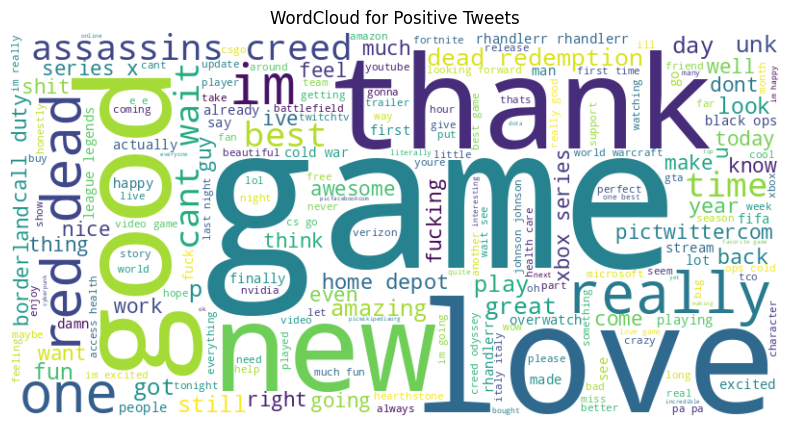

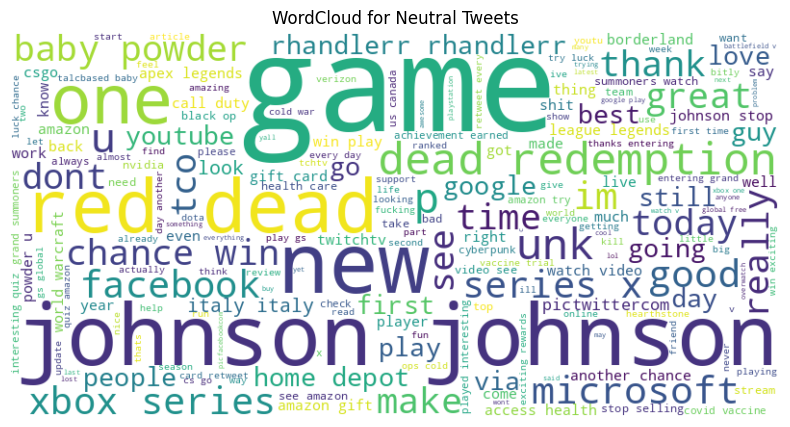

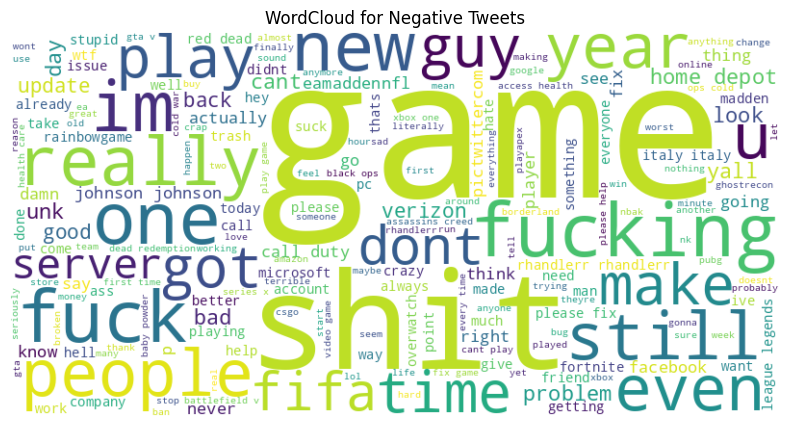

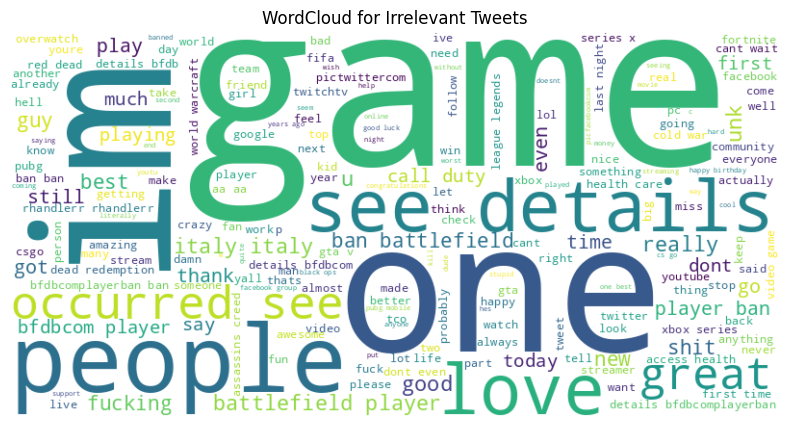

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sentiments = train_df['Sentiment'].unique()

for sentiment in sentiments:
    text = " ".join(train_df[train_df['Sentiment'] == sentiment]['clean_tweet'])
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(text)

    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {sentiment} Tweets")
    plt.show()

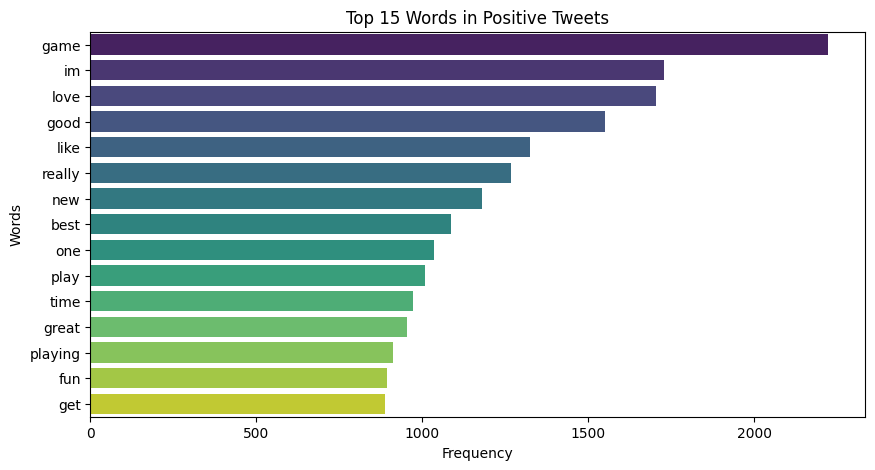

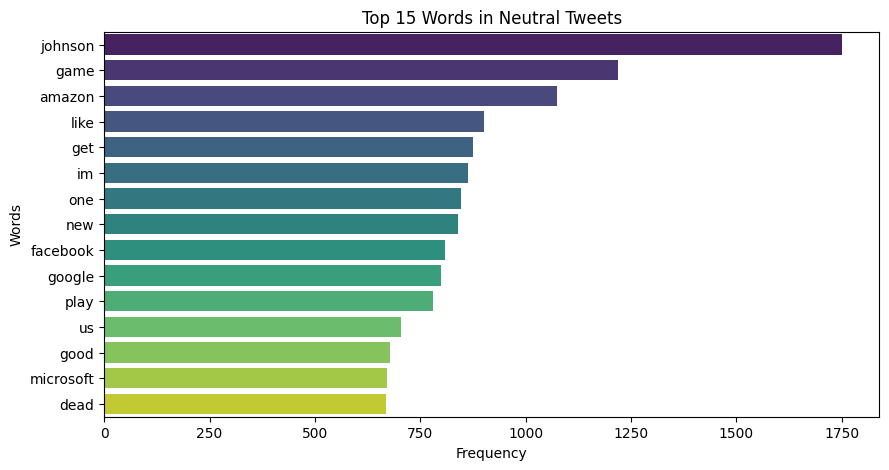

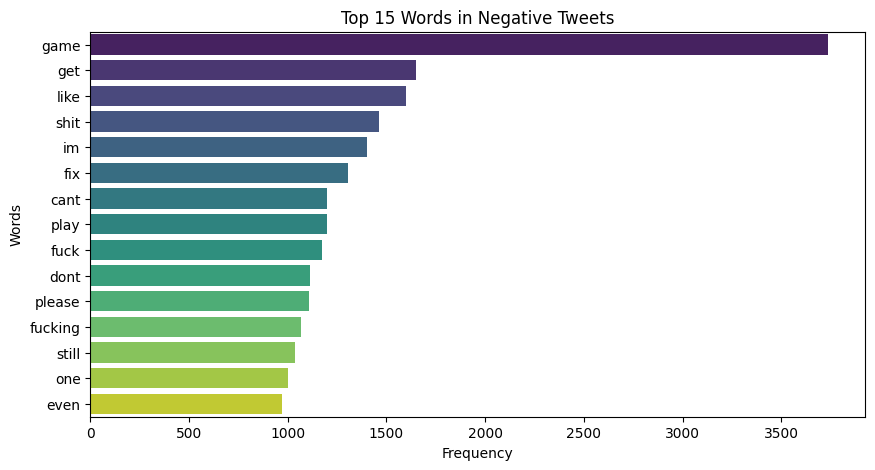

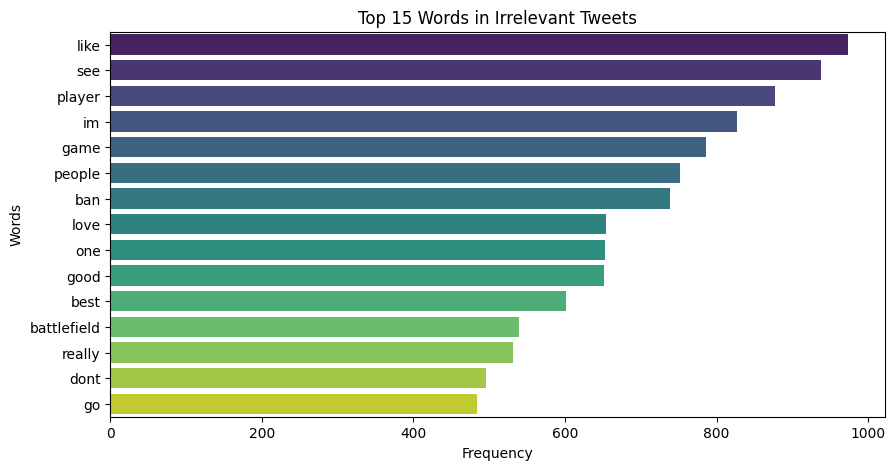

In [11]:
from nltk.probability import FreqDist

def plot_frequent_words(sentiment, n = 15):
    tweets = train_df[train_df['Sentiment'] == sentiment]['clean_tweet']
    all_words = " ".join(tweets).split()
    freq_dist = FreqDist(all_words)
    common_words = freq_dist.most_common(n)

    words, freqs = zip(*common_words)
    plt.figure(figsize = (10, 5))
    sns.barplot(x=list(freqs), y=list(words), hue=list(words), palette='viridis', dodge=False, legend=False)
    plt.title(f"Top {n} Words in {sentiment} Tweets")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

# Run for each sentiment
for sentiment in sentiments:
    plot_frequent_words(sentiment)

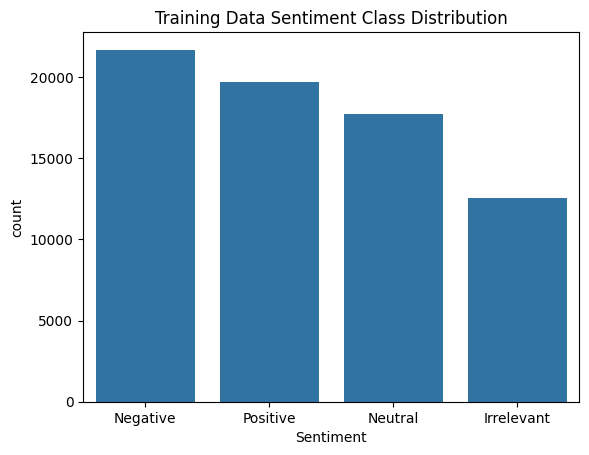

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data = train_df, x = 'Sentiment', order = train_df['Sentiment'].value_counts().index)
plt.title('Training Data Sentiment Class Distribution')
plt.show()

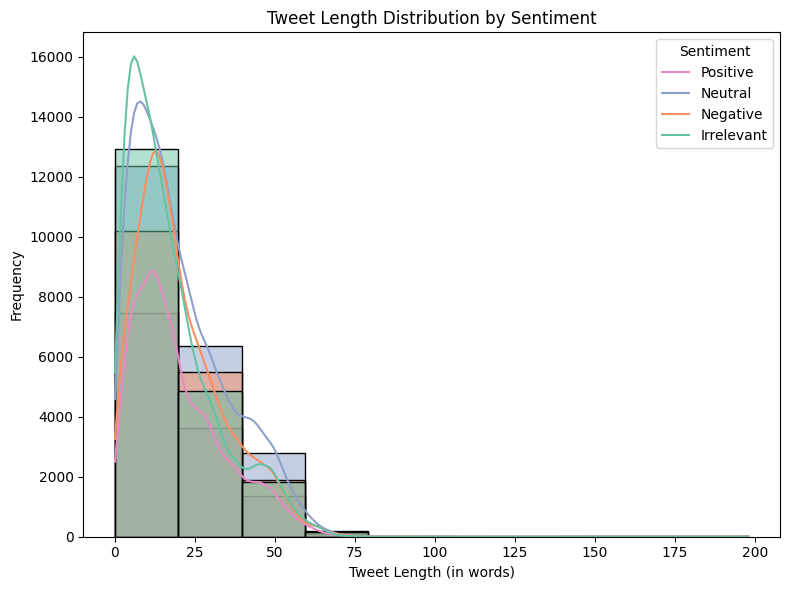

In [13]:
# Add tweet length in number of words
train_df['tweet_length'] = train_df['Tweet'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='tweet_length', hue='Sentiment', kde=True, bins=10, palette='Set2')
plt.title('Tweet Length Distribution by Sentiment')
plt.xlabel('Tweet Length (in words)')
plt.ylabel('Frequency')
plt.legend(title='Sentiment', labels=train_df['Sentiment'].unique())
plt.tight_layout()
plt.show()

##**BUILDING MODEL**

TF/IDF Vectorization

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features = 5000,
                        ngram_range = (1,2),
                        stop_words = 'english')


X_train_tfidf = tfidf.fit_transform(train_df['clean_tweet'])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_df['Sentiment'])

Logistic Regression model

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train_tfidf, y_train)


val_df['clean_tweet'] = val_df['Tweet'].astype(str).apply(clean_tweet)
X_val_tfidf = tfidf.transform(val_df['clean_tweet'])
y_val = le.transform(val_df['Sentiment'])


from sklearn.metrics import classification_report

y_pred = lr.predict(X_val_tfidf)
print(classification_report(y_val, y_pred, target_names = le.classes_))

              precision    recall  f1-score   support

  Irrelevant       0.75      0.70      0.73       172
    Negative       0.74      0.88      0.80       266
     Neutral       0.87      0.72      0.79       285
    Positive       0.80      0.83      0.81       277

    accuracy                           0.79      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79      0.79      0.79      1000



SVM model for comparison

In [16]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_val_tfidf)

print(classification_report(y_val, y_pred_svm, target_names = le.classes_))

              precision    recall  f1-score   support

  Irrelevant       0.80      0.76      0.78       172
    Negative       0.76      0.89      0.82       266
     Neutral       0.90      0.75      0.82       285
    Positive       0.82      0.85      0.83       277

    accuracy                           0.82      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.82      0.82      1000



Plotting both models' F1 Scores to compare and determine the best performing model.

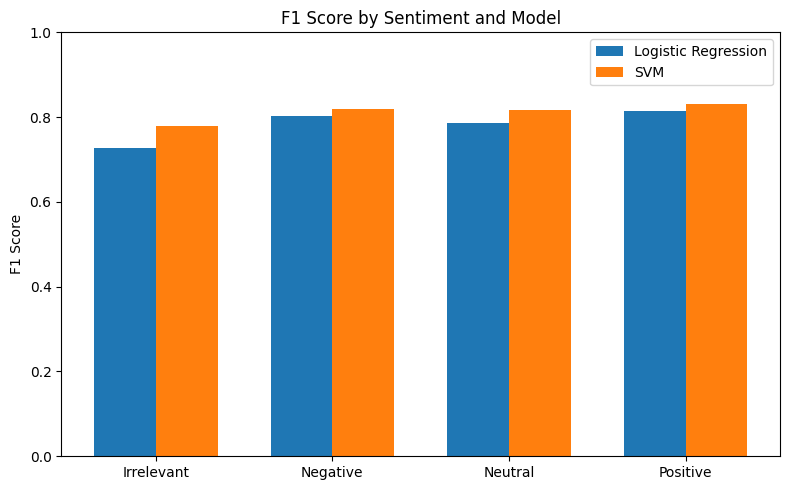

In [17]:
report_logreg = classification_report(y_val, y_pred, target_names = le.classes_, output_dict=True)
report_svm = classification_report(y_val, y_pred_svm, target_names = le.classes_, output_dict=True)

# Extract classes
classes = le.classes_

# Get F1 Scores
logreg_f1 = [report_logreg[cls]['f1-score'] for cls in classes]
svm_f1 = [report_svm[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, logreg_f1, width, label='Logistic Regression')
bars2 = ax.bar(x + width/2, svm_f1, width, label='SVM')

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Sentiment and Model')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0.0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()

Save the best model.

In [18]:
import joblib

joblib.dump(svm, 'svm_sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']